<a href="https://colab.research.google.com/github/Aniket-tempest/HAR-Employee-Identification/blob/main/HAR_DataInvestigationandVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
# HandleData: used for downloading dataset (txt) files and handle the data we get
'''

import os
import numpy as np
from pandas import read_csv

class DataHandler(object):

    # load a single txt file as a dataframe
    def load_txt(self, filedir):
        '''
        input:
            filedir: file full path
        
        output: returns numpy array
        '''
        data = read_csv(filedir, header=None, delim_whitespace=True)
        return data

    # load the files in the parnet dir and stack them together as numpy arrays
    def load_files(self, parentdir=''):
        
        '''
        input:
            parnetdir: parent directory of the target files
        
        output: returns stacked numpy arrays
        '''
        
        # get the name of files in the parent dir
        filelist = os.listdir(parentdir)
        
        # accumulator: a list for stroing loaded files
        loadedfiles = []
        
        # load all the files that exist in the filelist
        for file in filelist:
            data = self.load_txt(parentdir + file)
            loadedfiles.append(data)
            
        return np.dstack(loadedfiles)
    
    
    def remove_overlap(self, data, overlap_per=0.5):
        
        '''
        Pre-processed raw data had fixed windows of 2.56 seconds (128 data points) with a 50% overlap.
        For avoiding duplications due to overlapping in plotting or normalization steps on raw data,
        using this function we'll remove overlap and squash data frames it to the series. 
        
        input:
            data: dataset (e.g X_train or X_test)
            overlap_per: overlapping percentage (default is 0.5, as data has an overlap of 50% )
            
        output: squashed NumPy data
        '''
        
        # accumulator: a list for stroing squashed data
        series_data = []

        for frame in data:

            # get the overlap index  
            overlap_index = int(len(frame)* overlap_per) - 1
            # remove the overlap from the data frame
            series_data.append(frame[0:overlap_index])

        return np.concatenate(np.array(series_data))

In [ ]:
'''
some utility functions here
'''

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools


def plot_model_history(values, legend, title, ylabel='Accuracy', xlabel='Epoch', figure_size=(15,7)):
    
    '''
    Plot history values
    
    Parameters
    ----------
    history: python keras traning history
    ylabel&xlabel: labels for figure
    legend: legend labels for figure
    title: title of the figure
    val_label: labels for each data unit stored in the history  
    
    '''
    
    plt.figure(figsize=figure_size)
    
    
    if (type(title)!=str or title==None):
        raise ValueError
        
    if (values==None):
        raise ValueError
        
    if (type(legend)!=list or legend==None):
        raise ValueError
    
    for val_i in values:
        plt.plot(val_i)
        
    plt.title(title)
    
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(legend, loc='upper left')
    plt.show()
    

def plot_confusion_matrix(cm,
                          classes,
                          xlabel,
                          ylabel,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    Plot the given confusion matrix cm as a matrix using and return the
    resulting axes object containing the plot.
    Parameters
    ----------
    cm : ndarray
        Confusion matrix as a 2D numpy.array.
    classes : list of str
        Names of classified classes.
    xlabel : str
    Label of the horizontal axis.
    ylabel : str
    Label of the vertical axis.
    normalize : bool
        If True, the confusion matrix will be normalized. Otherwise, the values
        in the given confusion matrix will be plotted as they are.
    cmap : matplotlib.colormap
        Colormap to use when plotting the confusion matrix.
    Returns
    -------
    fig : matplotlib.figure
        Plot figure.
    ax : matplotlib.Axes
        matplotlib.Axes object with horizontal bar chart plotted.
    References
    ----------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    vmin = None
    vmax = None
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        vmin = 0
        vmax = 1

    plt.figure(figsize=(9, 9))
    cax = plt.imshow(
        cm, interpolation='nearest', vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(cax)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)


    plt.yticks(tick_marks,classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        cell_str = '{:.2f}'.format(cm[i, j]) if normalize else str(cm[i, j])
        plt.text(
            j,
            i,
            cell_str,
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
  
    plt.show()
    
    
def save_models_history(param_list, models_history, file_path):
    
    '''
    saves model history
    
    Parameters
    ----------
    param_list: params - possible parameters combinations for optimizations
    models_history: stores history values over n-fold of 
                    acc, loss, val_acc, val_loss for each params.
    '''

    data = []

    for i in range(len(models_history)):

        tmp_data=[]
        param_id = np.array(len(models_history[i]['val_accuracy'])*['hidden-{}, act-{}, nod-{}, opt-{}'.format(
              param_list[i]['hidden_layer_size'],
              param_list[i]['activation'],
              param_list[i]['node_size'],
              param_list[i]['optimizer']
              )])

        param_id = np.reshape(param_id, (param_id.shape[0], 1))

        for key in models_history[i].keys():
            tmp_data.append(np.reshape(models_history[i][key], (models_history[i][key].shape[0], 1)))

        history_values=np.hstack((param_id, tmp_data[0], tmp_data[1], tmp_data[2], tmp_data[3]))

        data.extend(history_values)

    # generate labels
    labels= list(models_history[i].keys())
    labels.insert(0, 'id')

    dataframe = pd.DataFrame(np.array(data), columns=labels)
    dataframe.to_csv(file_path, index=False, header=True)

In [ ]:
# HandleData: used for downloading dataset (txt) files and handle the data we get
datahandler = DataHandler()

In [ ]:
# get train data

prefix  = 'train'
X_train = datahandler.load_files('drive/MyDrive/UCI HAR Dataset/{p}/Inertial Signals/'.format(p=prefix))
y_train = datahandler.load_txt('drive/MyDrive/UCI HAR Dataset/{p}/y_{p}.txt'.format(p=prefix)).values

# get indices that map each (occurence) rows to their subject in the dataset
subject_mapping = datahandler.load_txt('drive/MyDrive/UCI HAR Dataset/{p}/subject_{p}.txt'.format(p=prefix)).values

In [ ]:
# PRINT DATA INFO

print('TRAIN\nX={}'.format(X_train.shape))
print('y={}'.format(y_train.shape))
print('activities={}'.format(np.unique(y_train)))
print('subjects={}\n'.format(np.unique(subject_mapping)))

TRAIN
X=(7352, 128, 9)
y=(7352, 1)
activities=[1 2 3 4 5 6]
subjects=[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]



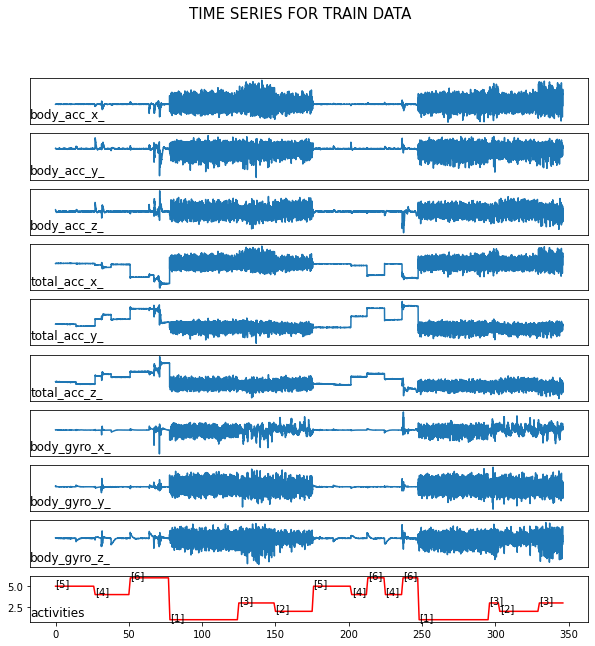

In [ ]:
def plot_time_series(data, target_data, subject_mapping, subject_id, signal_names, title):
    
    '''
    inputs:
        data: data (X) with the size of NxMxK, where
              N=obervation, M=series, K=features (number of inertial signals),
        traget_data: target data (y) contains labelled activities.
        subject_mapping: indices that map each (occurence) rows to their subject in the dataset
        subject_id: subject id we'll use we extracting subdata 
        signal_names: name of inertial signals (name of this K features).
        title: tiel for plot
        
    output: plot the time series
    '''
    # HANDLE DATA
    # retrive all observations (rows) for a given subject id
    sub_data = data[subject_mapping[:,0]==subject_id]
    sub_target_data = target_data[subject_mapping[:, 0]==subject_id]
    # remove overlap
    sub_data = datahandler.remove_overlap(sub_data)
    
    
    #### save this info to plot with bokeh
    
    
    # PLOT
    # create a subplot
    fig, ax = plt.subplots(nrows=len(signal_names)+1, ncols=1, figsize=(10,10), squeeze=True)

    # iterate over each signal
    for i in range(len(signal_names)):
        # add time series of corresponding inertial signal values
        ax[i].plot(sub_data[:, i])
        ax[i].set_title(signal_names[i][:-9], y=0, loc='left')
        # make axes unvisible
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)

    # add activity values to last ax
    ax[-1].plot(sub_target_data, 'r')
    ax[-1].set_title('activities', y=0, loc='left')
    
    # annotate activity number when there is a change
    temp_activity = 0
    for idx, activity in enumerate(sub_target_data): 
        if temp_activity!=activity: 
            temp_activity=activity
            ax[-1].annotate(str(activity), xy=(idx, activity))
    
    # add title and show plot
    fig.suptitle(title.upper(), fontsize=15)
    plt.show()
    
    
# get signal names 
signal_names = os.listdir('drive/MyDrive/UCI HAR Dataset/train/Inertial Signals/')
# plot raw data 
plot_time_series(X_train, y_train, subject_mapping, 1, signal_names, 'time series for train data')

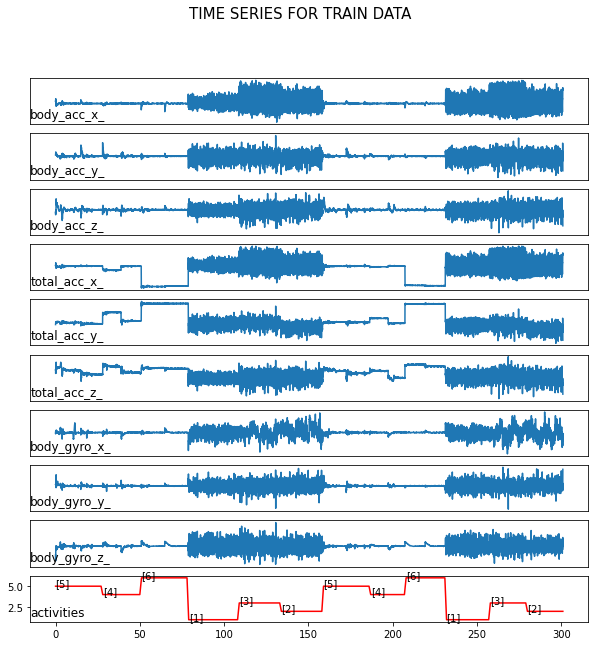

In [ ]:
plot_time_series(X_train, y_train, subject_mapping, 5, signal_names, 'time series for train data')

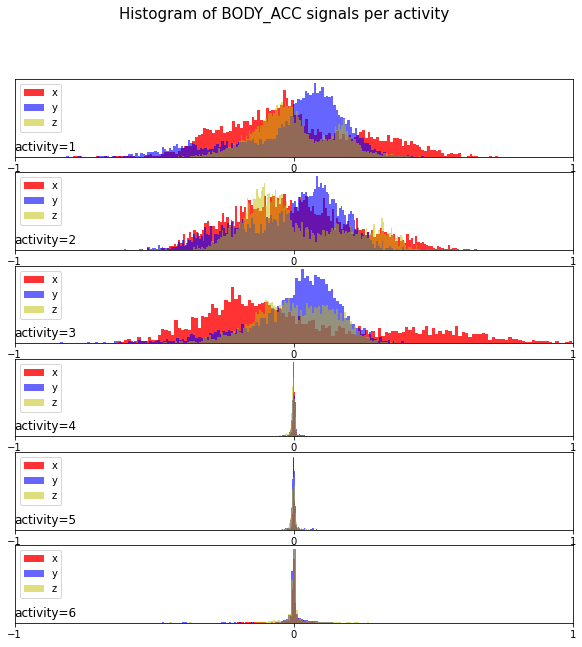

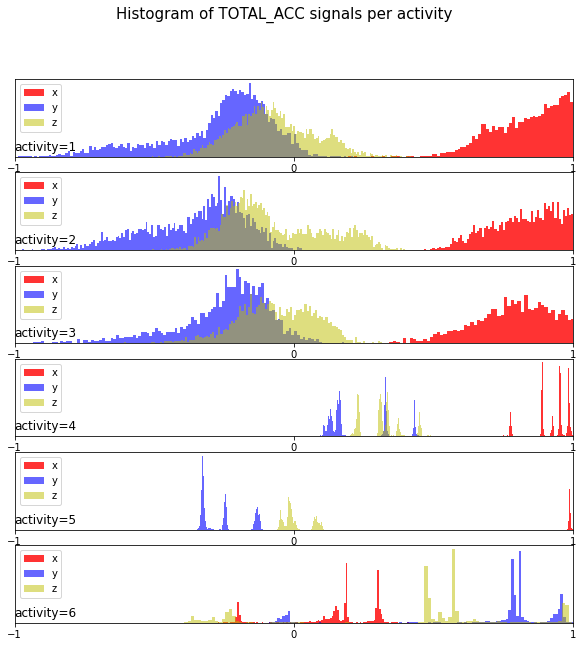

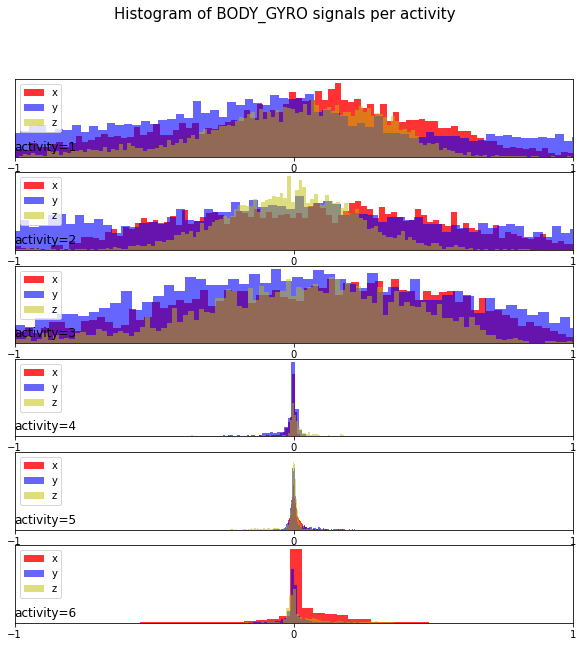

In [ ]:
def plot_activity_histogram(data, target_data, subject_mapping, subject_id, signal_names):
    
    '''
    inputs:
        data: data (X) with the size of NxMxK, where 
              N=obervation, M=series, K=features (number of inertial signals),
        traget_data: target data (y) contains labelled activities.
        subject_mapping: indices that map each (occurence) rows to their subject in the dataset
        subject_id: subject id we'll use we extracting subdata 
        signal_names: name of inertial signals (name of these K features).

    output: plot the activity histogram per activity per user
    '''
    # HANDLE DATA
    # retrive all observations (rows) for a given subject id
    data = data[subject_mapping[:,0]==subject_id]
    target_data = target_data[subject_mapping[:, 0]==subject_id]
    
    
    # iterate over signals by 3, becase for each signal type we have 3 differnet axes values
    for s_name in range(0, len(signal_names), 3):

        # get signal name
        _t_indx = signal_names[s_name].find('_t')
        signal = signal_names[s_name][:_t_indx-2]
        
        # greate a subplot for the signal type
        fig, ax = plt.subplots(nrows=len(np.unique(target_data)), ncols=1, figsize=(10,10), squeeze=True)
        
        # iterate over each activity
        for activity in np.unique(target_data):

            # HANDLE DATA
            # retrive all observations (rows) for a given activity
            sub_data = data[target_data[:,0]==activity]
            sub_target_data = target_data[target_data[:, 0]==activity]
            
            # remove overlap
            sub_data = datahandler.remove_overlap(sub_data)

            # PLOT
            # add x,y,z data to histogram
            ax[activity-1].hist(sub_data[:,s_name], bins=150, alpha = 0.8, color='r', label='x')
            ax[activity-1].hist(sub_data[:,s_name+1], bins=150, alpha = 0.6, color='b', label='y')
            ax[activity-1].hist(sub_data[:,s_name+2], bins=150, alpha = 0.5, color='y', label='z')
    
            # add title and legend
            ax[activity-1].set_title("activity={}".format(activity), y=0, loc='left')
            ax[activity-1].legend(loc='upper left')
            
            # simplify axes
            ax[activity-1].get_yaxis().set_visible(False)
            ax[activity-1].set_xlim(-1,1)
            ax[activity-1].set_xticks([-1,0,1])
            
        # add fig title and show plot
        fig.suptitle("Histogram of {} signals per activity".format(signal.upper()), fontsize=15)
        plt.show()
        
        
plot_activity_histogram(X_train, y_train, subject_mapping, 1, signal_names)
